In [1]:
# Bring your packages onto the path
import sys, os
# include directory 3 levels up 
# for 1 level up '..' 
# for 2 levels '../..'
sys.path.append(os.path.abspath(os.path.join('../..')))

In [2]:
import Models.Heat_Conduction.Heat_2D_FEM as Heat_2D_FEM
import numpy as np
factorial = np.math.factorial

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import collections as mc

# custom module where PCE functions are written
import Surrogates.PolynomialChaosExpansion as PCE

In [2]:
def GaussLegendreQuadrature(lowerlimit, upperlimit, number_of_quadrature_points):

    # numpy method that provides Gauß-Legendre quadrature points and weights 
    quad_points, quad_weights = np.polynomial.legendre.leggauss(number_of_quadrature_points)

    # scaling for change of interval from [-1, 1] to [a, b]
    quad_points = ( (upperlimit-lowerlimit)/2 ) * quad_points + ( (upperlimit+lowerlimit)/2 )
    quad_weights = ( (upperlimit-lowerlimit)/2 ) * quad_weights

    return quad_points, quad_weights

In [3]:
def PlateQuadrature(plate_corners, quad_points_in_x, quad_points_in_y, plot = True):

    total_quad_points = quad_points_in_x*quad_points_in_y

    X_quad_points, X_quad_weights = GaussLegendreQuadrature(plate_corners[0], plate_corners[2], quad_points_in_x)
    Y_quad_points, Y_quad_weights = GaussLegendreQuadrature(plate_corners[1], plate_corners[3], quad_points_in_y)

    X_grid, Y_grid = np.meshgrid(X_quad_points, Y_quad_points)
    X_weight_grid, Y_weight_grid = np.meshgrid(X_quad_weights, Y_quad_weights)

    X_grid = np.reshape(X_grid, [-1,1])
    Y_grid = np.reshape(Y_grid, [-1,1])

    X_weight_grid = np.reshape(X_weight_grid, [-1, 1])
    Y_weight_grid = np.reshape(Y_weight_grid, [-1, 1])

    # [X_coord, Y_coord, X_weight*Y_weight]
    Quad_coord_weight_matrix = np.hstack((X_grid, Y_grid, X_weight_grid, Y_weight_grid))

    if plot == True:

        fig, ax = plt.subplots()

        plate_edges = [ [(0, 0), (0.5, 0)],       # lower edge
                        [(0, 0), (0, 0.25)],      # left edge
                        [(0, 0.25), (0.5, 0.25)], # upper edge 
                        [(0.5, 0), (0.5, 0.25)] ] # right edge 

        # numbering quadrature points 
        for i, txt in enumerate(np.arange(total_quad_points)):
            ax.annotate(txt+1, (X_grid[i] + 0.005, Y_grid[i]) )

        lc = mc.LineCollection(plate_edges, color = 'blue', linewidths=2)
        ax.plot(X_grid, Y_grid, '.', markersize=3, color = 'black')
        ax.add_collection(lc)
        ax.autoscale()
        ax.margins(0.1)
        ax.set_title('2D Gauß-Legendre Quadrature')
        plt.show()

    return total_quad_points, Quad_coord_weight_matrix

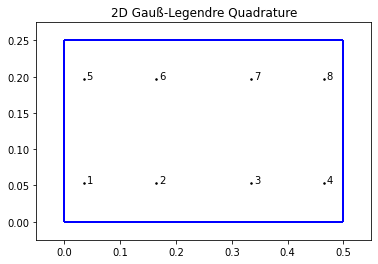

In [4]:
# X0, Y0, X1, Y1 
plate_corners = [0, 0, 0.5, 0.25] 

quad_points_in_x = 4
quad_points_in_y = 2
 
total_quad_points, Quadrature_matrix = PlateQuadrature(plate_corners, quad_points_in_x, quad_points_in_y)

quad_weights = Quadrature_matrix[:, 2] * Quadrature_matrix[:, 3]

# convert quad_weights vector to diagonal matrix
quad_weights = np.diag(quad_weights)

# find square root of weights
sqrt_quad_weights = np.sqrt(quad_weights)

In [5]:
# nEleX = number of elements in the X-direction
# nEleY = number of elements in the Y-direction
nEleX = 4
nEleY = nEleX/2

model = Heat_2D_FEM.Heat_2D_FEM_solver(nEleX, nEleY)

# lambda_x = Thermal Conductivity in the X-direction
# lambda_y = Thermal Conductivity in the Y-direction 

# Number of realizations
N = 50

a = [1, 3] 
b = [1, 3]  

lambda_x = np.random.uniform(a[0], a[1],(N,1))
lambda_y = np.random.uniform(b[0], b[1],(N,1))

SampleSpace = np.hstack((lambda_x, lambda_y))

# matrix to store solution corresponding 
# to each realization of random variable
# size: [N, number of quadrature points]
func_evaluations = np.zeros((N, total_quad_points))

for i in range(N):

    _, solution_u, solution_quad_points = model.solve(lambda_x[i], lambda_y[i], Quadrature_matrix[:,:2])

    func_evaluations[i,:] = solution_quad_points.flatten()

In [6]:
Y = np.copy(func_evaluations)

Y_mean = np.mean(Y, axis=0) # compute mean for each (x_i, y_i)
Y_std = np.std(Y, axis=0) # compute std for each (x_i, y_i)

# center the process
Y_c = Y-Y_mean

Variance quantified by 3 terms = 0.9999999994475737


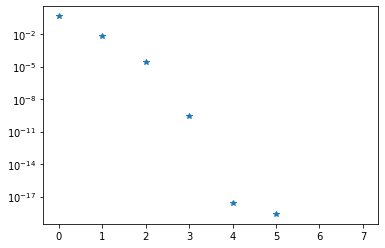

In [7]:
# Covariance matrix
# size: [N_quad, N_quad]
# unbiased estimator: 1/(N-1)
K = (1/(N-1))*np.dot(Y_c.T,Y_c)

# Pre and post multiply covariance matrix with
# square root of quadrature weights
K_new = sqrt_quad_weights @ K @ sqrt_quad_weights

# Eigenvalue Decomposition
eig_values, eig_vectors = np.linalg.eig(K_new)

# Compute true eigenvectors
weighted_eig_vectors = np.linalg.inv(sqrt_quad_weights) @ eig_vectors

# Discard imaginary part, as eigenvalues are real
eig_values = np.real(eig_values)

# Sort eigenvalues in descending order
# reverse sign -> sort in ascending -> reverse sign again
eig_values = -np.sort(-eig_values)

# truncation of KL expansion
n_kl = 3

# variance quantified by a given truncation level: n_kl
r_kl = np.sum(eig_values[:n_kl])/np.sum(eig_values)

print("Variance quantified by", n_kl, "terms =", r_kl)

# plot of eigenvalues
plt.semilogy(eig_values, '*')
plt.show()

In [8]:
# truncate eigenvector space
trunc_eig_vectors = weighted_eig_vectors[:,:n_kl] 

# project f_c (bzw. Y_c) on eigenvectors
# resulting matrix has size [N x n_kl]
# N evaluations for each of the n_kl vectors
Y_i =  Y_c @ quad_weights @ trunc_eig_vectors

# Plot Eigenvectors

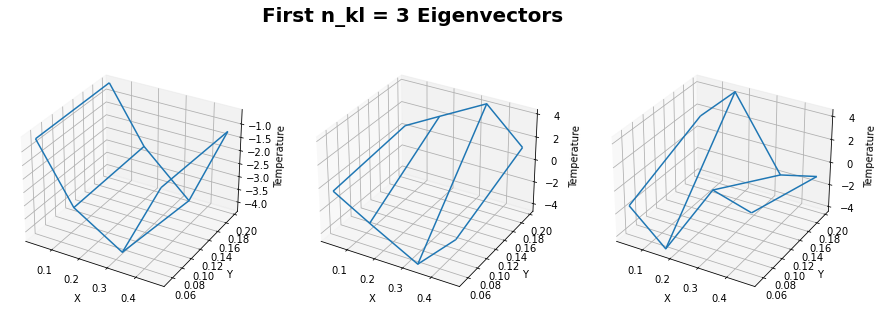

In [9]:
# fig = plt.figure(figsize=plt.figaspect(0.5))

# Create figure outside the loop
fig = plt.figure(figsize=(15, 5))

X_quad_points, _ = GaussLegendreQuadrature(plate_corners[0], plate_corners[2], quad_points_in_x)
Y_quad_points, _ = GaussLegendreQuadrature(plate_corners[1], plate_corners[3], quad_points_in_y)

X_grid, Y_grid = np.meshgrid(X_quad_points, Y_quad_points)


for i in np.arange(n_kl):

    # Eigenvector i
    EV_i = trunc_eig_vectors[:,i].reshape(quad_points_in_y, quad_points_in_x)

    ax = fig.add_subplot(1, n_kl, i+1, projection='3d')

    # Plot a basic wireframe
    ax.plot_wireframe(X_grid, Y_grid, EV_i, rstride = 1, cstride = 1)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Temperature')

fig.suptitle("First n_kl = " + str(n_kl) + " Eigenvectors", fontsize=20, fontweight= "bold")

# Show it outside the loop
plt.show()

# Dot Product

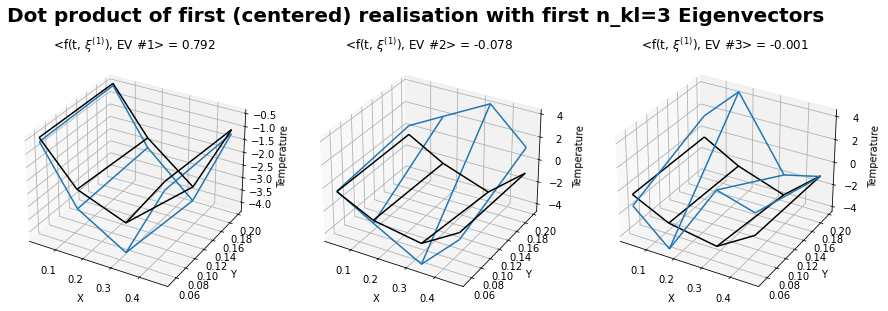

In [10]:
# fig = plt.figure(figsize=plt.figaspect(0.5))

# Create figure outside the loop
fig = plt.figure(figsize=(15, 5))

X_quad_points, _ = GaussLegendreQuadrature(plate_corners[0], plate_corners[2], quad_points_in_x)
Y_quad_points, _ = GaussLegendreQuadrature(plate_corners[1], plate_corners[3], quad_points_in_y)

X_grid, Y_grid = np.meshgrid(X_quad_points, Y_quad_points)

# Temperature plot of the first realisation 
T = Y_c[0,:].reshape(quad_points_in_y, quad_points_in_x)

for i in np.arange(n_kl):

    # Eigenvector i
    EV_i = trunc_eig_vectors[:,i].reshape(quad_points_in_y, quad_points_in_x)

    # Dot product
    dot_prod_i = np.around(np.real(Y_i[0,i]), 3)

    ax = fig.add_subplot(1, n_kl, i+1, projection='3d')

    # Plot a basic wireframe
    ax.plot_wireframe(X_grid, Y_grid, EV_i, rstride = 1, cstride = 1)
    ax.plot_wireframe(X_grid, Y_grid, T, color="black", rstride = 1, cstride = 1)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Temperature')

    ax.set_title(r'<f(t, $\xi^{(1)}$), EV #' + str(i+1) + '> = ' + str(dot_prod_i))

fig.suptitle("Dot product of first (centered) realisation with first n_kl=" + str(n_kl) + " Eigenvectors", fontsize=20, fontweight= "bold")

# Show it outside the loop
plt.show()

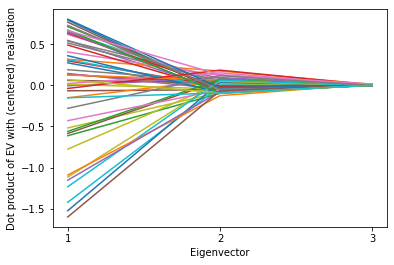

In [11]:
plt.plot(np.arange(1, n_kl+1), np.real(Y_i[:100]).T)
plt.xticks(np.arange(1, n_kl+1, step=1))  # Set label locations.
plt.xlabel('Eigenvector')
plt.ylabel('Dot product of EV with (centered) realisation')
plt.show()

In [12]:
def isoprobabilistic_transform(any_X):

    temp = np.copy(any_X)

    temp[:,0] = ( temp[:,0] - ( a[1] + a[0] )/2 )/ ( ( a[1] - a[0] )/2 )
    temp[:,1] = ( temp[:,1] - ( b[1] + b[0] )/2 )/ ( ( b[1] - b[0] )/2 )

    return temp

In [13]:
class KLE_PCE_surrogate(PCE.PCE_surrogate):
    
    # Inherit from class PCE_surrogate from PolynomialChaosExpansion module

    '''
    Inputs:
    
        SampleSpace : Samples of random variables [N, N_p]
        
        n_kl : truncation level of KL-expansion
        
        n : total polynomial order
        
        func_vals : evaluated values of eigen_modes 
                    using which surrogate must be constructed [N x n_kl]
        
        eig_values : eigenvalues of the covariance operator
        
    
    Outputs:
    
        Generalised Sobol indices : [N_p, 1]
                                    history-aware index @ t = T of all random variables
    
    '''

    def __init__(self, X, func_evals, total_polynomial_degree, polynomial_classes_of_random_variables, eig_values, n_kl, isoprob_transform):

        self.X = X
        self.func_evals = func_evals
        self.n = total_polynomial_degree
        self.pcrv = polynomial_classes_of_random_variables 
        self.N_p = len(self.pcrv)
        self.eig_values = eig_values
        self.n_kl = n_kl
        self.isoprob_transform = isoprob_transform

        # set classes of random variables
        for i in range(self.N_p):
            
            if self.pcrv[i] == 'Hermite':
                self.pcrv[i] = PCE.Hermite

            if self.pcrv[i] == 'Legendre':
                self.pcrv[i] = PCE.Legendre

        # total number of polynomial terms in the PCE
        self.number_of_PCE_terms = int (factorial(self.N_p+self.n) / ( factorial(self.N_p) * factorial(self.n) ))

        # compute all permutations of monomials which have total degree <= n
        self.all_permutations, self.comb_dict = PCE.compute_all_permutations(self.n, self.N_p)


    def generalised_Sobol(self):

        first_order_picker, total_order_picker = self.coefficient_pickers()

        # store coefficients of polynomial surrogates
        # each column contains polynomial coefficients corresponding to each point(x_m, y_n)
        # size = [number_of_PCE_terms, number of quadrature points] '''
        store_beta = np.zeros((self.number_of_PCE_terms, self.n_kl))

        for i in range(self.n_kl):

            store_beta[:,i] = self.find_coefficients(self.X, self.func_evals[:,i])

        # sum of squares of coefficients of eigenmodes for a given random varible
        # size [N_p, 1]
        G_first_numerator = np.sum(first_order_picker @ (store_beta**2), axis = 1)
        G_total_numerator = np.sum(total_order_picker @ (store_beta**2), axis = 1)

        # sum of eigenvalues for total variance
        # size [N_p, 1]
        G_denominator = np.sum(self.eig_values[:self.n_kl])

        # first order generalised Sobol index
        # size [N_p, 1]
        self.G_first = G_first_numerator/G_denominator

        # total generalised Sobol index
        # size [N_p, 1]
        self.G_tot = G_total_numerator/G_denominator
        
        'Plots'
        fig, ax = plt.subplots(1, 2, figsize=(15,5))

        'Histogram of general total Sobol indices at t=T'
        params = ['lambda_y=' + str(np.around(self.G_tot[0], 4)), 
                  'lambda_y='  + str(np.around(self.G_tot[1], 4))]

        ax[0].bar(params, self.G_tot)
        ax[0].set_xlabel('Parameters')
        ax[0].set_ylabel('Total General Sobol indices')

        'Histogram of first order general Sobol indices at t=T'
        params = ['lambda_x=' + str(np.around(self.G_first[0], 4)), 
                  'lambda_y='  + str(np.around(self.G_first[1], 4))]

        ax[1].bar(params, self.G_first)
        ax[1].set_xlabel('Parameters')
        ax[1].set_ylabel('First order General Sobol indices')

        plt.show()

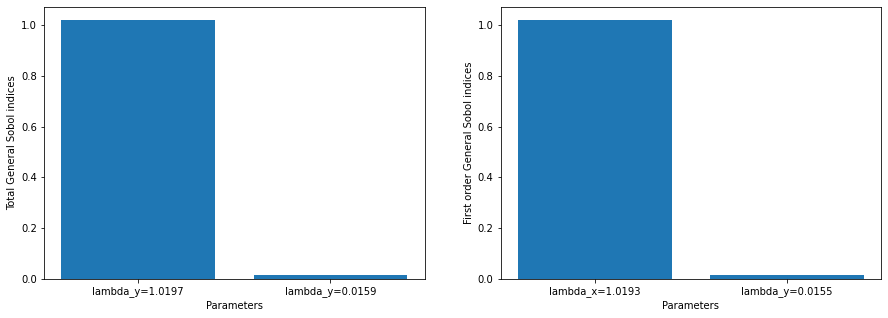

In [14]:
total_polynomial_degree = 5
polynomial_classes_of_random_variables = ['Legendre', 'Legendre']

KLE_modes_PCE = KLE_PCE_surrogate(SampleSpace, Y_i, total_polynomial_degree, polynomial_classes_of_random_variables, eig_values, n_kl, isoprobabilistic_transform)

KLE_modes_PCE.generalised_Sobol()